# 1. Dataset preprocessing

In [1]:
import csv
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Multiply, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

path = r"Datasets\10000Dataset224.npy"
data = np.load(path, allow_pickle=True).item()
df = pd.DataFrame(data)
# # create DataFrame
# df = pd.DataFrame(data)

# path = r"cassava-leaf-disease-classification\Dataset.csv"
# dataset = pd.read_csv(path)
# dataset = df.sample(n=10000, random_state=42)
dataset = df
# np.save(r"cassava-leaf-disease-classification\10000Dataset224.npy", dataset.to_dict(orient='list'))

images_o = np.stack(dataset['image_matrices'].values)
labels_o = dataset['labels'].values
# labels = np.array(labels, dtype=np.int32)

print(images_o.shape)
print(labels_o)

# data preprocessing
images = np.array(images_o).astype('float32') / 255.0  # Normalizaion
labels = tf.keras.utils.to_categorical(labels_o)  # convert label to one-hot code

# split train_test dadtaset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

(10000, 224, 224, 3)
['4' '3' '3' ... '3' '0' '0']


## 1.1 Plot images

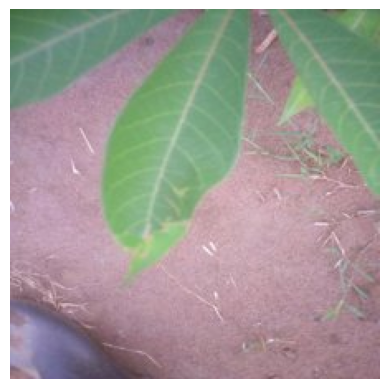

['4' '3' '3' ... '3' '0' '0']
['0' '1' '2' '3' '4']
[ 503 1020 1078 6215 1184]


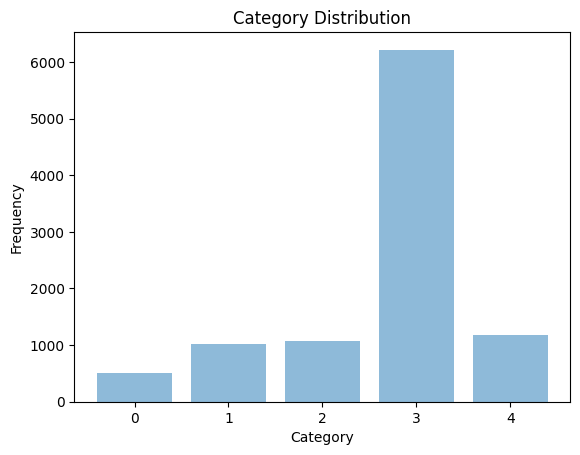

In [8]:
def plot_image(image_array):
    plt.imshow(image_array)
    plt.axis('off') 
    plt.show()

def plot_labels(label):
    print(label)
    unique, counts = np.unique(label, return_counts=True)
    # Plotting
    print(unique)
    print(counts)
    plt.bar(unique, counts, align='center', alpha=0.5)
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.title('Category Distribution')
    plt.show()
plot_image(images[0])
plot_labels(labels_o)

# 2. Model training

## 2.1 Primitive CNN model

In [4]:
class PrintEpochProgress(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs

    def on_train_begin(self, logs=None):
        self.epoch_progress = tqdm(total=self.total_epochs, desc='Epochs', position=0)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress.update(1)
        self.epoch_progress.set_postfix(loss=f"{logs['loss']:.4f}", accuracy=f"{logs['accuracy']:.4f}", val_loss=f"{logs['val_loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}")
        

# CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') 
])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

progress_callback = PrintEpochProgress(total_epochs=10)

# train model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping, checkpoint])

# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/30
113/113 [==============================] - 8s 64ms/step - loss: 1.1878 - accuracy: 0.6121 - val_loss: 1.1015 - val_accuracy: 0.6325

Epoch 00001: val_accuracy improved from -inf to 0.63250, saving model to best_model.h5
Epoch 2/30
113/113 [==============================] - 7s 58ms/step - loss: 1.0906 - accuracy: 0.6161 - val_loss: 0.9823 - val_accuracy: 0.6400

Epoch 00002: val_accuracy improved from 0.63250 to 0.64000, saving model to best_model.h5
Epoch 3/30
113/113 [==============================] - 6s 57ms/step - loss: 1.0366 - accuracy: 0.6339 - val_loss: 0.9958 - val_accuracy: 0.6513

Epoch 00003: val_accuracy improved from 0.64000 to 0.65125, saving model to best_model.h5
Epoch 4/30
113/113 [==============================] - 6s 56ms/step - loss: 1.0014 - accuracy: 0.6364 - val_loss: 0.9395 - val_accuracy: 0.6587

Epoch 00004: val_accuracy improved from 0.65125 to 0.65875, saving model to best_model.h5
Epoch 5/30
113/113 [==============================] - 6s 56ms/step 

## 2.2 Attention-based Pre-trained CNN model 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Multiply, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)
        

def attention_module(feature_map, input_channels):
    # Use 1x1 convolution to reduce dimensionality
    attention_features = Conv2D(filters=input_channels, kernel_size=(1, 1), padding='same')(feature_map)
    # Generate attention mask
    attention_mask = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(attention_features)
    # Apply attention mask to feature map through multiplication
    attention_applied = Multiply()([feature_map, attention_mask])
    return attention_applied, attention_mask

def global_weighted_average_pooling(feature_map, attention_mask):
    # Weight feature map
    weighted_feature_map = Multiply()([feature_map, attention_mask])
    # Sum attention mask
    sum_attention = tf.reduce_sum(attention_mask, axis=[1, 2], keepdims=True)
    # Weighted average pooling
    weighted_average_pool = weighted_feature_map / (sum_attention + tf.keras.backend.epsilon())
    # Global average pooling
    gap = tf.reduce_sum(weighted_average_pool, axis=[1, 2])
    return gap

# Input layer
input_shape = (224, 224, 3) 
inputs = Input(shape=input_shape)

# Pre-trained model
pre_model = EfficientNetB4(include_top=False, input_tensor=inputs)
x = pre_model.output

# for layer in pre_model.layers:
#     layer.trainable = False

print(x.shape)

# Batch normalization
x = BatchNormalization()(x)

# First additional convolutional layer
x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Second additional convolutional layer
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)

# # Second additional convolutional layer
# x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Attention module
x, attention_mask = attention_module(x, input_channels=pre_model.output_shape[-1])

# Global weighted average pooling
x = global_weighted_average_pooling(x, attention_mask)

# Classification head
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)  

# Define the model
model = Model(inputs=inputs, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=30,
                    batch_size=32,
                    verbose=0, # Set verbose to 0 to avoid duplicate output
                    callbacks=[CustomCallback(total_epochs=30, steps_per_epoch=len(X_train)//32), early_stopping, checkpoint]
                    )  # Print epoch progress

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

(None, 7, 7, 1792)


Epoch 1/30:   2%|▏         | 6/250 [00:24<07:01,  1.73s/it]  

Epoch 1/30:  90%|█████████ | 225/250 [02:11<00:14,  1.71it/s]


    loss: 1.3335 - accuracy: 0.5318 - val_loss: 1.1720 - val_accuracy: 0.6325

Epoch 00001: val_accuracy improved from -inf to 0.63250, saving model to best_model.h5


d:\anaconda\envs\normal\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 2/30:  90%|█████████ | 225/250 [01:58<00:13,  1.89it/s]


    loss: 1.1188 - accuracy: 0.6158 - val_loss: 1.1671 - val_accuracy: 0.6325

Epoch 00002: val_accuracy did not improve from 0.63250


Epoch 3/30:  90%|█████████ | 225/250 [02:06<00:14,  1.78it/s]


    loss: 1.0484 - accuracy: 0.6219 - val_loss: 1.0546 - val_accuracy: 0.6338

Epoch 00003: val_accuracy improved from 0.63250 to 0.63375, saving model to best_model.h5


Epoch 4/30:  90%|█████████ | 225/250 [02:06<00:14,  1.78it/s]


    loss: 0.9961 - accuracy: 0.6332 - val_loss: 0.9542 - val_accuracy: 0.6538

Epoch 00004: val_accuracy improved from 0.63375 to 0.65375, saving model to best_model.h5


Epoch 5/30:  90%|█████████ | 225/250 [02:04<00:13,  1.80it/s]


    loss: 0.9499 - accuracy: 0.6508 - val_loss: 0.9103 - val_accuracy: 0.6775

Epoch 00005: val_accuracy improved from 0.65375 to 0.67750, saving model to best_model.h5


Epoch 6/30:  90%|█████████ | 225/250 [02:07<00:14,  1.77it/s]


    loss: 0.9085 - accuracy: 0.6706 - val_loss: 0.8817 - val_accuracy: 0.6888

Epoch 00006: val_accuracy improved from 0.67750 to 0.68875, saving model to best_model.h5


Epoch 7/30:  90%|█████████ | 225/250 [02:06<00:14,  1.79it/s]


    loss: 0.8762 - accuracy: 0.6851 - val_loss: 0.8619 - val_accuracy: 0.6950

Epoch 00007: val_accuracy improved from 0.68875 to 0.69500, saving model to best_model.h5


Epoch 8/30:  90%|█████████ | 225/250 [02:07<00:14,  1.77it/s]


    loss: 0.8420 - accuracy: 0.6906 - val_loss: 0.8334 - val_accuracy: 0.7050

Epoch 00008: val_accuracy improved from 0.69500 to 0.70500, saving model to best_model.h5


Epoch 9/30:  90%|█████████ | 225/250 [02:10<00:14,  1.72it/s]


    loss: 0.8284 - accuracy: 0.6888 - val_loss: 0.8158 - val_accuracy: 0.7175

Epoch 00009: val_accuracy improved from 0.70500 to 0.71750, saving model to best_model.h5


Epoch 10/30:  90%|█████████ | 225/250 [02:11<00:14,  1.71it/s]


    loss: 0.7988 - accuracy: 0.7026 - val_loss: 0.7986 - val_accuracy: 0.7200

Epoch 00010: val_accuracy improved from 0.71750 to 0.72000, saving model to best_model.h5


Epoch 11/30:  90%|█████████ | 225/250 [02:11<00:14,  1.72it/s]


    loss: 0.7664 - accuracy: 0.7175 - val_loss: 0.7899 - val_accuracy: 0.7212

Epoch 00011: val_accuracy improved from 0.72000 to 0.72125, saving model to best_model.h5


Epoch 12/30:  90%|█████████ | 225/250 [02:11<00:14,  1.71it/s]


    loss: 0.7590 - accuracy: 0.7203 - val_loss: 0.7807 - val_accuracy: 0.7250

Epoch 00012: val_accuracy improved from 0.72125 to 0.72500, saving model to best_model.h5


Epoch 13/30:  90%|█████████ | 225/250 [02:10<00:14,  1.72it/s]


    loss: 0.7281 - accuracy: 0.7358 - val_loss: 0.7725 - val_accuracy: 0.7250

Epoch 00013: val_accuracy did not improve from 0.72500


Epoch 14/30:  90%|█████████ | 225/250 [02:10<00:14,  1.72it/s]


    loss: 0.7194 - accuracy: 0.7360 - val_loss: 0.7632 - val_accuracy: 0.7300

Epoch 00014: val_accuracy improved from 0.72500 to 0.73000, saving model to best_model.h5


Epoch 15/30:  90%|█████████ | 225/250 [02:06<00:14,  1.77it/s]


    loss: 0.6974 - accuracy: 0.7406 - val_loss: 0.7582 - val_accuracy: 0.7312

Epoch 00015: val_accuracy improved from 0.73000 to 0.73125, saving model to best_model.h5


Epoch 16/30:  90%|█████████ | 225/250 [02:07<00:14,  1.77it/s]


    loss: 0.6774 - accuracy: 0.7543 - val_loss: 0.7500 - val_accuracy: 0.7300

Epoch 00016: val_accuracy did not improve from 0.73125


Epoch 17/30:  90%|█████████ | 225/250 [02:04<00:13,  1.80it/s]


    loss: 0.6553 - accuracy: 0.7567 - val_loss: 0.7462 - val_accuracy: 0.7275

Epoch 00017: val_accuracy did not improve from 0.73125


Epoch 18/30:  90%|█████████ | 225/250 [02:02<00:13,  1.83it/s]


    loss: 0.6474 - accuracy: 0.7636 - val_loss: 0.7479 - val_accuracy: 0.7300

Epoch 00018: val_accuracy did not improve from 0.73125


Epoch 19/30:  90%|█████████ | 225/250 [02:03<00:13,  1.82it/s]


    loss: 0.6301 - accuracy: 0.7665 - val_loss: 0.7466 - val_accuracy: 0.7312

Epoch 00019: val_accuracy did not improve from 0.73125


Epoch 20/30:  90%|█████████ | 225/250 [02:04<00:13,  1.81it/s]


    loss: 0.6206 - accuracy: 0.7744 - val_loss: 0.7473 - val_accuracy: 0.7350
Restoring model weights from the end of the best epoch.

Epoch 00020: val_accuracy improved from 0.73125 to 0.73500, saving model to best_model.h5
Epoch 00020: early stopping
63/63 [==============================] - 9s 110ms/step - loss: 0.7111 - accuracy: 0.7430
Test Loss: 0.7111296653747559
Test Accuracy: 0.7429999709129333


## 2.3 Deep gaussian CNN model (The operation encountered issues: Aborted.)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from gpflow.kernels import SquaredExponential
from gpflow.mean_functions import Constant
from gpflow.models import GPR, SVGP
import gpflow
from gpflow.likelihoods import Gaussian
from tensorflow.keras.layers import Softmax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)


# Create Convolutional Neural Network (CNN) model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False))  # Add pre-trained MobileNetV2 model
    print(model.output_shape)
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    for _ in range(10):  # Add 10 fully connected layers, each with 100 units, using ReLU activation function
        model.add(Dense(100, activation='relu'))
    return model

# Create DGP model
def create_dgp_model(input_shape, num_inducing_points):
    # Define the kernel function
    kernel = gpflow.kernels.SquaredExponential()

    # Define the inducing variable locations
    Z = np.random.rand(num_inducing_points, input_shape[0])

    # Define the mean function as a constant
    mean_function = gpflow.mean_functions.Constant()

    # Define the likelihood
    likelihood = gpflow.likelihoods.Gaussian()

    # Create the deep GP model
    dgp_model = SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=Z, mean_function=mean_function)

    # Convert the input shape to a tensor
    dgp_input = Input(shape=input_shape)

    # Get the predictions from the DGP model
    dgp_model_output = dgp_model.predict_f(dgp_input)[0]

    # Create a fully connected layer and apply the softmax activation function
    output_layer = Dense(5, activation='softmax')(dgp_model_output)

    # Create a new model that takes the input tensor and connects it to the output layer
    new_dgp_model = Model(inputs=dgp_input, outputs=output_layer)

    return new_dgp_model

# Create Keras Sequential model integrating CNN and DGP models
def create_dgcnn_model(cnn_model, dgp_model):
    dgcnn_model = Sequential()
    dgcnn_model.add(cnn_model)
    dgcnn_model.add(dgp_model)  # Add DGP model as prediction layer
    return dgcnn_model

# Set the shape of input data
input_shape = (224, 224, 3)  # Assume input image size is 224x224, 3 channels for RGB
num_inducing_points = 100

# Create CNN model and DGP model
cnn_model = create_cnn_model(input_shape)
cnn_output_shape = cnn_model.output_shape[1:]
dgp_model = create_dgp_model(cnn_output_shape, num_inducing_points)

# Create DGCNN model integrating CNN and DGP models
dgcnn_model = create_dgcnn_model(cnn_model, dgp_model)

# Compile the model
likelihood_loss = Gaussian()
dgcnn_model.compile(optimizer='adam', loss=likelihood_loss)

# Fit the model
dgcnn_model.fit(X_train, y_train,
                validation_split=0.1,
                epochs=10,
                batch_size=32,
                verbose=0,  # Set verbose to 0 to avoid duplicate output
                callbacks=[CustomCallback(total_epochs=10, steps_per_epoch=len(X_train)//32)])

(None, 7, 7, 1280)


AssertionError: (None, 100)

## 2.4 Attention-based custom CNN model 

In [2]:

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)

def attention_module(feature_map, input_channels):
    # Use 1x1 convolution to reduce dimensionality
    attention_features = Conv2D(filters=input_channels, kernel_size=(1, 1), padding='same')(feature_map)
    # Generate attention mask
    attention_mask = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(attention_features)
    # Apply attention mask to feature map through multiplication
    attention_applied = Multiply()([feature_map, attention_mask])
    return attention_applied, attention_mask

def global_weighted_average_pooling(feature_map, attention_mask):
    # Weight feature map
    weighted_feature_map = Multiply()([feature_map, attention_mask])
    # Sum attention mask
    sum_attention = tf.reduce_sum(attention_mask, axis=[1, 2], keepdims=True)
    # Weighted average pooling
    weighted_average_pool = weighted_feature_map / (sum_attention + tf.keras.backend.epsilon())
    # Global average pooling
    gap = tf.reduce_sum(weighted_average_pool, axis=[1, 2])
    return gap

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Input layer
input_shape = (224, 224, 3) 
inputs = Input(shape=input_shape)


# First Conv2D layer
x = Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))(inputs)
x = MaxPooling2D((2, 2))(x)

# Second Conv2D layer
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Third Conv2D layer
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Fourth Conv2D layer
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


# Attention module
x, attention_mask = attention_module(x, input_channels=128)

# Global average pooling
x = GlobalAveragePooling2D()(x)

# Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

# Compile the model
model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=64,
                    verbose=0, # Set verbose to 0 to avoid duplicate output
                    callbacks=[CustomCallback(total_epochs=50, steps_per_epoch=len(X_train)//64), early_stopping, checkpoint]
                    )  # Print epoch progress

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)




Epoch 1/50:   4%|▍         | 5/125 [00:06<01:47,  1.11it/s]

Epoch 1/50:  90%|█████████ | 113/125 [00:14<00:01,  7.62it/s]
d:\anaconda\envs\normal\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


    loss: 1.2356 - accuracy: 0.6111 - val_loss: 1.1129 - val_accuracy: 0.6325

Epoch 00001: val_accuracy improved from -inf to 0.63250, saving model to best_model.h5


Epoch 2/50:  90%|█████████ | 113/125 [00:06<00:00, 17.65it/s]


    loss: 1.1428 - accuracy: 0.6169 - val_loss: 1.1282 - val_accuracy: 0.6325

Epoch 00002: val_accuracy did not improve from 0.63250


Epoch 3/50:  90%|█████████ | 113/125 [00:06<00:00, 18.29it/s]


    loss: 1.0932 - accuracy: 0.6271 - val_loss: 1.0539 - val_accuracy: 0.6388

Epoch 00003: val_accuracy improved from 0.63250 to 0.63875, saving model to best_model.h5


Epoch 4/50:  90%|█████████ | 113/125 [00:06<00:00, 18.27it/s]


    loss: 1.0555 - accuracy: 0.6303 - val_loss: 0.9713 - val_accuracy: 0.6463

Epoch 00004: val_accuracy improved from 0.63875 to 0.64625, saving model to best_model.h5


Epoch 5/50:  90%|█████████ | 113/125 [00:06<00:00, 18.31it/s]


    loss: 1.0206 - accuracy: 0.6326 - val_loss: 1.0369 - val_accuracy: 0.6488

Epoch 00005: val_accuracy improved from 0.64625 to 0.64875, saving model to best_model.h5


Epoch 6/50:  90%|█████████ | 113/125 [00:06<00:00, 18.51it/s]


    loss: 0.9978 - accuracy: 0.6404 - val_loss: 0.9601 - val_accuracy: 0.6562

Epoch 00006: val_accuracy improved from 0.64875 to 0.65625, saving model to best_model.h5


Epoch 7/50:  90%|█████████ | 113/125 [00:06<00:00, 18.57it/s]


    loss: 0.9885 - accuracy: 0.6421 - val_loss: 0.9368 - val_accuracy: 0.6662

Epoch 00007: val_accuracy improved from 0.65625 to 0.66625, saving model to best_model.h5


Epoch 8/50:  90%|█████████ | 113/125 [00:06<00:00, 18.40it/s]


    loss: 0.9585 - accuracy: 0.6513 - val_loss: 0.9325 - val_accuracy: 0.6587

Epoch 00008: val_accuracy did not improve from 0.66625


Epoch 9/50:  90%|█████████ | 113/125 [00:06<00:00, 18.37it/s]


    loss: 0.9518 - accuracy: 0.6517 - val_loss: 0.9542 - val_accuracy: 0.6575

Epoch 00009: val_accuracy did not improve from 0.66625


Epoch 10/50:  90%|█████████ | 113/125 [00:06<00:00, 17.93it/s]


    loss: 0.9488 - accuracy: 0.6503 - val_loss: 0.9409 - val_accuracy: 0.6587

Epoch 00010: val_accuracy did not improve from 0.66625


Epoch 11/50:  90%|█████████ | 113/125 [00:06<00:00, 18.46it/s]


    loss: 0.9329 - accuracy: 0.6565 - val_loss: 0.8944 - val_accuracy: 0.6825

Epoch 00011: val_accuracy improved from 0.66625 to 0.68250, saving model to best_model.h5


Epoch 12/50:  90%|█████████ | 113/125 [00:06<00:00, 18.56it/s]


    loss: 0.9182 - accuracy: 0.6635 - val_loss: 0.8882 - val_accuracy: 0.6862

Epoch 00012: val_accuracy improved from 0.68250 to 0.68625, saving model to best_model.h5


Epoch 13/50:  90%|█████████ | 113/125 [00:06<00:00, 18.32it/s]


    loss: 0.8938 - accuracy: 0.6696 - val_loss: 0.8551 - val_accuracy: 0.6888

Epoch 00013: val_accuracy improved from 0.68625 to 0.68875, saving model to best_model.h5


Epoch 14/50:  90%|█████████ | 113/125 [00:06<00:00, 18.40it/s]


    loss: 0.8903 - accuracy: 0.6690 - val_loss: 0.9058 - val_accuracy: 0.6762

Epoch 00014: val_accuracy did not improve from 0.68875


Epoch 15/50:  90%|█████████ | 113/125 [00:06<00:00, 18.44it/s]


    loss: 0.8666 - accuracy: 0.6801 - val_loss: 0.8382 - val_accuracy: 0.6925

Epoch 00015: val_accuracy improved from 0.68875 to 0.69250, saving model to best_model.h5


Epoch 16/50:  90%|█████████ | 113/125 [00:06<00:00, 18.27it/s]


    loss: 0.8547 - accuracy: 0.6833 - val_loss: 0.8525 - val_accuracy: 0.6900

Epoch 00016: val_accuracy did not improve from 0.69250


Epoch 17/50:  90%|█████████ | 113/125 [00:06<00:00, 18.17it/s]


    loss: 0.8434 - accuracy: 0.6872 - val_loss: 0.8155 - val_accuracy: 0.6900

Epoch 00017: val_accuracy did not improve from 0.69250


Epoch 18/50:  90%|█████████ | 113/125 [00:06<00:00, 18.35it/s]


    loss: 0.8390 - accuracy: 0.6835 - val_loss: 0.8414 - val_accuracy: 0.6925

Epoch 00018: val_accuracy did not improve from 0.69250


Epoch 19/50:  90%|█████████ | 113/125 [00:05<00:00, 18.93it/s]


    loss: 0.8186 - accuracy: 0.6949 - val_loss: 0.8049 - val_accuracy: 0.7038

Epoch 00019: val_accuracy improved from 0.69250 to 0.70375, saving model to best_model.h5


Epoch 20/50:  90%|█████████ | 113/125 [00:05<00:00, 18.86it/s]


    loss: 0.7947 - accuracy: 0.7035 - val_loss: 0.8139 - val_accuracy: 0.7063

Epoch 00020: val_accuracy improved from 0.70375 to 0.70625, saving model to best_model.h5


Epoch 21/50:  90%|█████████ | 113/125 [00:06<00:00, 18.40it/s]


    loss: 0.7927 - accuracy: 0.7038 - val_loss: 0.7842 - val_accuracy: 0.7025

Epoch 00021: val_accuracy did not improve from 0.70625


Epoch 22/50:  90%|█████████ | 113/125 [00:06<00:00, 17.25it/s]


    loss: 0.7695 - accuracy: 0.7113 - val_loss: 0.7413 - val_accuracy: 0.7175

Epoch 00022: val_accuracy improved from 0.70625 to 0.71750, saving model to best_model.h5


Epoch 23/50:  90%|█████████ | 113/125 [00:06<00:00, 18.27it/s]


    loss: 0.7727 - accuracy: 0.7067 - val_loss: 0.7417 - val_accuracy: 0.7163

Epoch 00023: val_accuracy did not improve from 0.71750


Epoch 24/50:  90%|█████████ | 113/125 [00:06<00:00, 18.37it/s]


    loss: 0.7466 - accuracy: 0.7229 - val_loss: 0.7076 - val_accuracy: 0.7325

Epoch 00024: val_accuracy improved from 0.71750 to 0.73250, saving model to best_model.h5


Epoch 25/50:  90%|█████████ | 113/125 [00:06<00:00, 17.43it/s]


    loss: 0.7218 - accuracy: 0.7297 - val_loss: 0.6916 - val_accuracy: 0.7450

Epoch 00025: val_accuracy improved from 0.73250 to 0.74500, saving model to best_model.h5


Epoch 26/50:  90%|█████████ | 113/125 [00:06<00:00, 17.52it/s]


    loss: 0.7174 - accuracy: 0.7308 - val_loss: 0.7005 - val_accuracy: 0.7437

Epoch 00026: val_accuracy did not improve from 0.74500


Epoch 27/50:  90%|█████████ | 113/125 [00:06<00:00, 18.21it/s]


    loss: 0.7012 - accuracy: 0.7374 - val_loss: 0.6934 - val_accuracy: 0.7375

Epoch 00027: val_accuracy did not improve from 0.74500


Epoch 28/50:  90%|█████████ | 113/125 [00:06<00:00, 17.23it/s]


    loss: 0.6773 - accuracy: 0.7449 - val_loss: 0.7133 - val_accuracy: 0.7450

Epoch 00028: val_accuracy did not improve from 0.74500


Epoch 29/50:  90%|█████████ | 113/125 [00:06<00:00, 17.21it/s]


    loss: 0.6894 - accuracy: 0.7421 - val_loss: 0.7561 - val_accuracy: 0.7312

Epoch 00029: val_accuracy did not improve from 0.74500


Epoch 30/50:  90%|█████████ | 113/125 [00:06<00:00, 17.62it/s]


    loss: 0.6667 - accuracy: 0.7510 - val_loss: 0.6739 - val_accuracy: 0.7450

Epoch 00030: val_accuracy did not improve from 0.74500


Epoch 31/50:  90%|█████████ | 113/125 [00:06<00:00, 17.58it/s]


    loss: 0.6484 - accuracy: 0.7586 - val_loss: 0.6686 - val_accuracy: 0.7437

Epoch 00031: val_accuracy did not improve from 0.74500


Epoch 32/50:  90%|█████████ | 113/125 [00:06<00:00, 17.56it/s]


    loss: 0.6268 - accuracy: 0.7694 - val_loss: 0.6944 - val_accuracy: 0.7450

Epoch 00032: val_accuracy did not improve from 0.74500


Epoch 33/50:  90%|█████████ | 113/125 [00:06<00:00, 17.65it/s]


    loss: 0.6031 - accuracy: 0.7710 - val_loss: 0.6522 - val_accuracy: 0.7638

Epoch 00033: val_accuracy improved from 0.74500 to 0.76375, saving model to best_model.h5


Epoch 34/50:  90%|█████████ | 113/125 [00:06<00:00, 17.54it/s]


    loss: 0.5856 - accuracy: 0.7794 - val_loss: 0.7709 - val_accuracy: 0.7188

Epoch 00034: val_accuracy did not improve from 0.76375


Epoch 35/50:  90%|█████████ | 113/125 [00:06<00:00, 17.05it/s]


    loss: 0.5868 - accuracy: 0.7761 - val_loss: 0.6999 - val_accuracy: 0.7550

Epoch 00035: val_accuracy did not improve from 0.76375


Epoch 36/50:  90%|█████████ | 113/125 [00:06<00:00, 17.18it/s]


    loss: 0.5320 - accuracy: 0.8011 - val_loss: 0.6467 - val_accuracy: 0.7700

Epoch 00036: val_accuracy improved from 0.76375 to 0.77000, saving model to best_model.h5


Epoch 37/50:  90%|█████████ | 113/125 [00:06<00:00, 17.48it/s]


    loss: 0.5014 - accuracy: 0.8149 - val_loss: 0.6916 - val_accuracy: 0.7400

Epoch 00037: val_accuracy did not improve from 0.77000


Epoch 38/50:  90%|█████████ | 113/125 [00:06<00:00, 17.49it/s]


    loss: 0.4789 - accuracy: 0.8228 - val_loss: 0.7454 - val_accuracy: 0.7500

Epoch 00038: val_accuracy did not improve from 0.77000


Epoch 39/50:  90%|█████████ | 113/125 [00:06<00:00, 17.48it/s]


    loss: 0.4520 - accuracy: 0.8343 - val_loss: 0.7687 - val_accuracy: 0.7312

Epoch 00039: val_accuracy did not improve from 0.77000


Epoch 40/50:  90%|█████████ | 113/125 [00:06<00:00, 17.46it/s]


    loss: 0.4262 - accuracy: 0.8460 - val_loss: 0.6650 - val_accuracy: 0.7738

Epoch 00040: val_accuracy improved from 0.77000 to 0.77375, saving model to best_model.h5


Epoch 41/50:  90%|█████████ | 113/125 [00:06<00:00, 17.44it/s]


    loss: 0.3705 - accuracy: 0.8661 - val_loss: 0.7802 - val_accuracy: 0.7500
Restoring model weights from the end of the best epoch.

Epoch 00041: val_accuracy did not improve from 0.77375
Epoch 00041: early stopping
63/63 [==============================] - 1s 15ms/step - loss: 0.6780 - accuracy: 0.7545
Test Loss: 0.6780009865760803
Test Accuracy: 0.7544999718666077


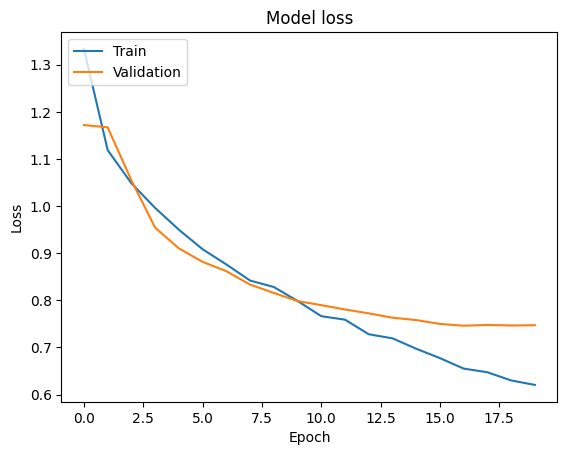

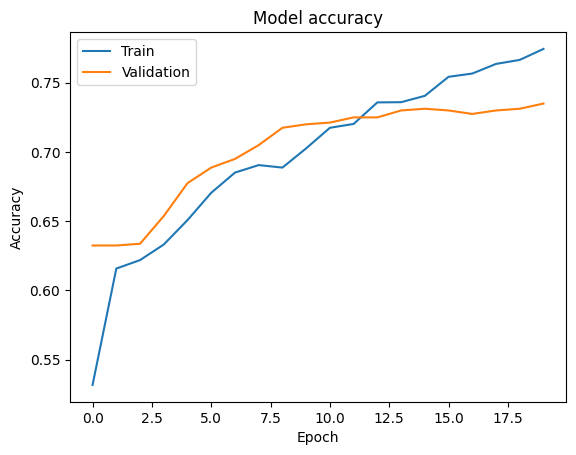

In [3]:
def plot_history(history, save_path=None):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_path + '10^6_loss.png')
    plt.show()
    plt.clf()  # Clear the figure to plot the next graph

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_path + '10^6_accuracy.png')
    plt.show()
        
plot_history(history, '')

## 2.5 SVM classification

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Get feature map from the model trained before
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

train_features = feature_extractor.predict(X_train)
print(train_features.shape)
test_features = feature_extractor.predict(X_test)

# Convert multi-class target variable to one-dimensional array
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# train SVM
svm_model = SVC(kernel='rbf', C = 1)
svm_model.fit(train_features, y_train_flat)

# evaluate model on test set
y_pred = svm_model.predict(test_features)
accuracy = accuracy_score(y_test_flat, y_pred)
print("Accuracy:", accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.